In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datalab_utils
import astropy.units as u
from dl import authClient as ac, queryClient as qc

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [78]:
# lc_df = pd.read_parquet("/dlusers/adriansh/work/analyses/results/strings/lensed_lightcurves_all.parquet")
lc_df = pd.concat([pd.read_parquet(f"/dlusers/adriansh/work/analyses/results/strings/temp/lensed_lightcurves_batch{i}.parquet").assign(batch=i)
                   for i in range(9)])

In [79]:
lc_df.sort_values(by=["batch", "mjd"], inplace=True)

In [80]:
results_df = datalab_utils.make_lensing_dataframe(lc_df)

In [81]:
results_df = results_df.assign(delta_t=((results_df["t_end"] - results_df["t_start"]) * 24))

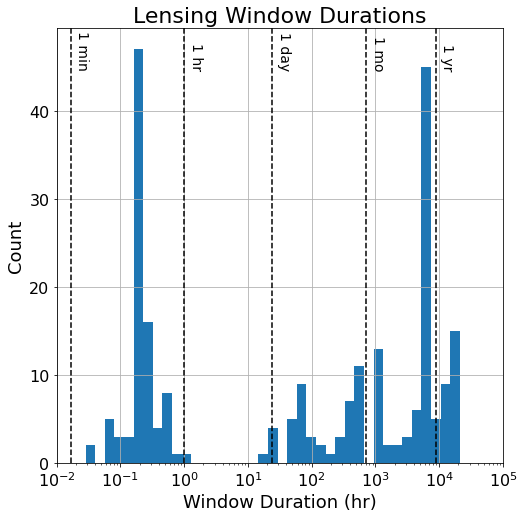

In [7]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
bins = np.geomspace(results_df["delta_t"].min(), results_df["delta_t"].max() + 1, num=40)

fig, ax = plt.subplots(figsize=(8, 8))
results_df.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, ylabelsize=16)
ax.set_xscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((1e-2, 1e5))
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.91)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations.png")
plt.close(fig)

In [8]:
quantiles = [.1, 0.25, 0.5, 0.75, 0.9]
results_df["delta_t"].quantile(q=quantiles) / 24

0.10      0.007149
0.25      0.009196
0.50     12.911534
0.75    265.085787
0.90    441.357927
Name: delta_t, dtype: float64

In [9]:
event_types = results_df.groupby(by="filters").t_start.agg("count")

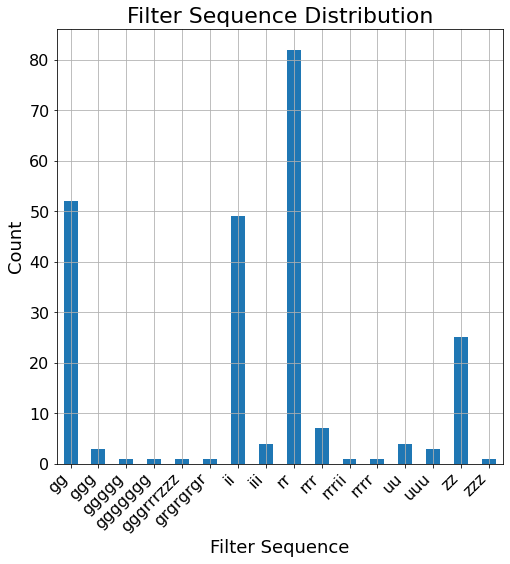

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
event_types.plot.bar(ax=ax)
ax.set_xlabel("Filter Sequence", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Filter Sequence Distribution", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(visible=True)
plt.show(fig)
# fig.savefig(f"{fig_dir}filter_category_bar.png")
plt.close(fig)

In [82]:
mask_achromatic = results_df.apply(lambda x: len(set(x["filters"])) > 1, axis=1)
achromatic_ids = results_df.loc[mask_achromatic].index
n_achromatic = len(achromatic_ids)
n_achromatic

5

In [83]:
dmag_df = datalab_utils.subtract_baseline(lc_df)

In [84]:
flux_double = -2.5 * np.log10(2)

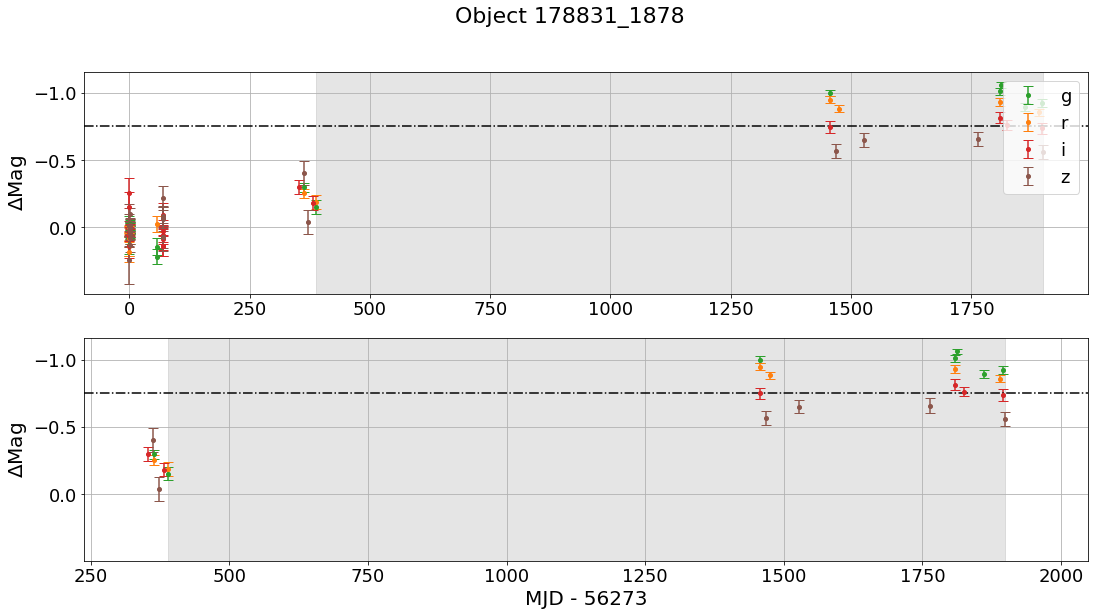

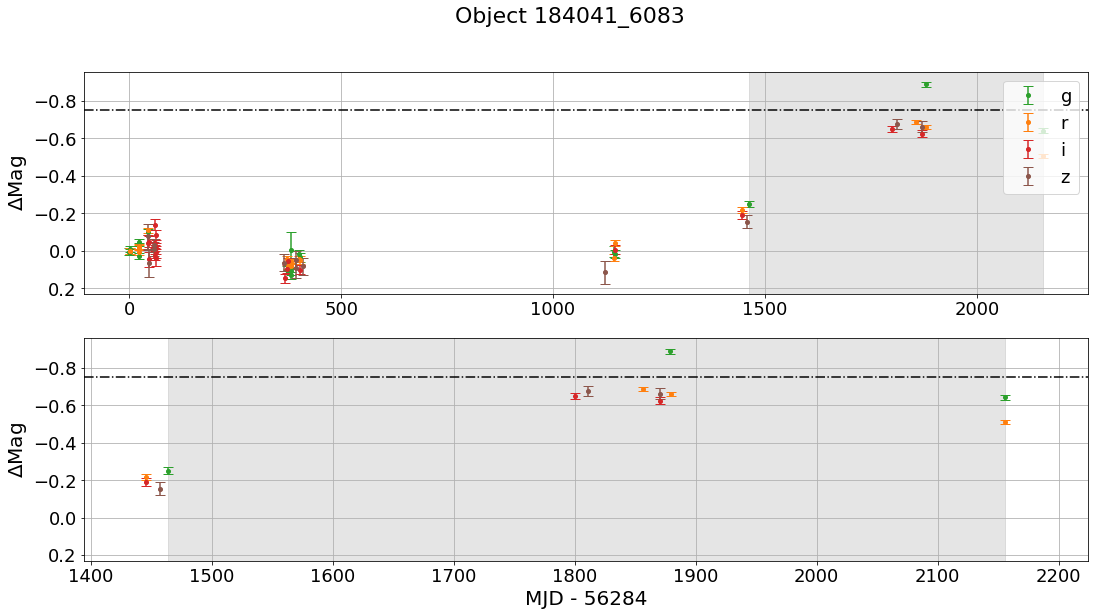

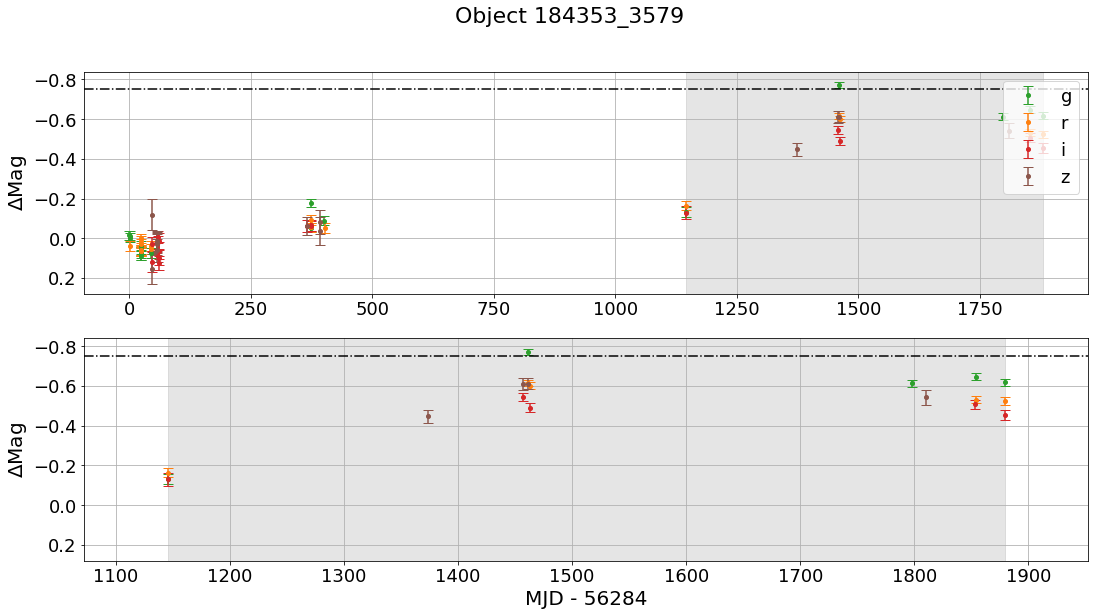

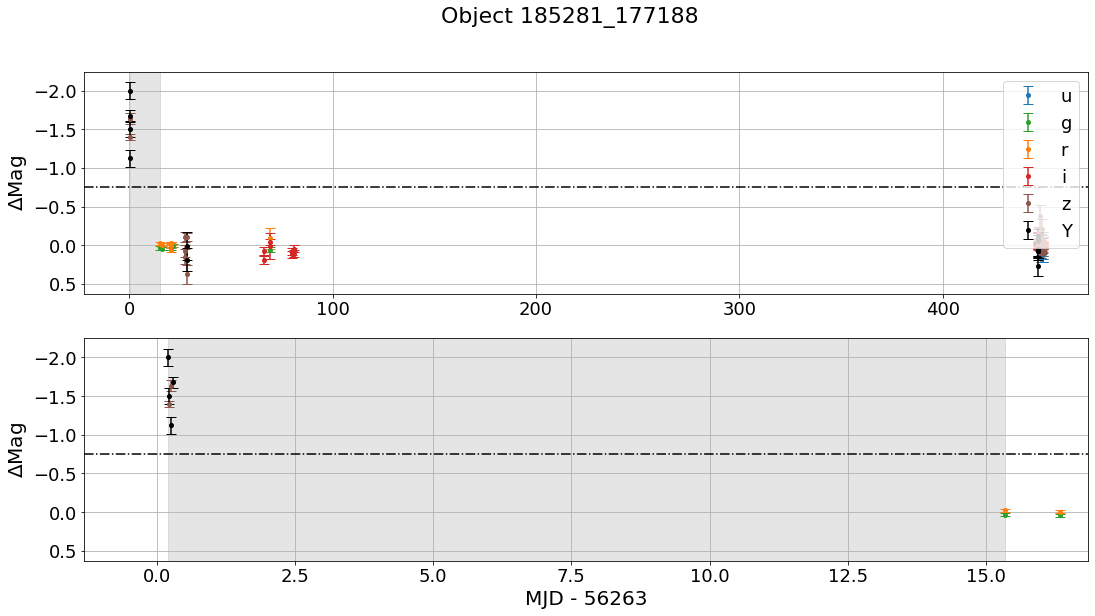

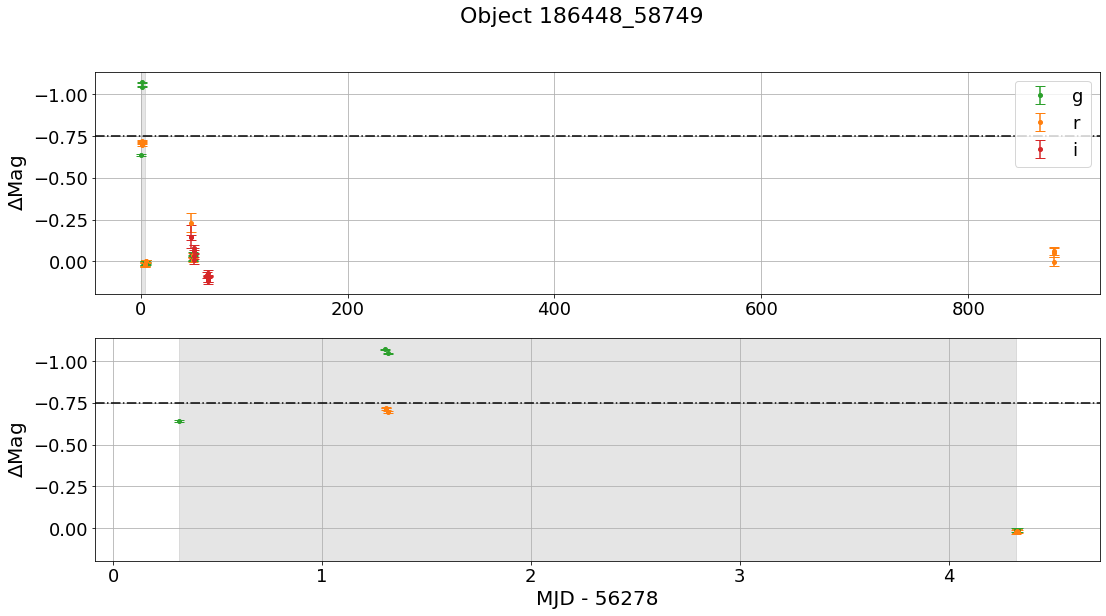

In [85]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])

for oid in achromatic_ids:
    fig, axes = plt.subplots(2, 1, figsize=(18, 9))
    row = results_df.loc[oid]
    ev_start, ev_end = row["t_start"], row["t_end"]
    m_id = dmag_df["objectid"] == oid

    if np.isnan(ev_start):
        ev_start = dmag_df.loc[m_id, "mjd"].min()
    if np.isnan(ev_end):
        ev_end = dmag_df.loc[m_id, "mjd"].max()

    t_delta = ev_end - ev_start
    min_mjd = int(dmag_df.loc[m_id, "mjd"].min())
    

    for f, c in zip(filters, colors):
        m_f = dmag_df["filter"] == f
        lc_full = dmag_df.loc[m_id & m_f]

        if len(lc_full) > 0:
            axes[0].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None", label=f)
            axes[1].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")

    for ax in axes:
        ax.set_ylabel(r'$\Delta$Mag', fontsize=20)
        ax.tick_params(labelsize=18)
        ax.invert_yaxis()
        ax.grid(visible=True)
        barlims = (ev_start - min_mjd, ev_end - min_mjd)
        ax.axvspan(barlims[0], barlims[1], alpha=0.2, color="tab:gray")
        ax.axhline(flux_double, color='k', linestyle="-.")
        
    legend = axes[0].legend(fontsize=18, loc="upper right")
    axes[1].set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    t_lims = ((ev_start - 0.1 * t_delta) - min_mjd, (ev_end + 0.1 * t_delta) - min_mjd)
    axes[1].set_xlim(t_lims)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{oid}_lightcurve_baseline_subtracted.png")
    plt.close(fig)

In [86]:
mask_achromatic_dmag = dmag_df["objectid"].isin(achromatic_ids)

In [87]:
dmag_achromatic = dmag_df.loc[mask_achromatic_dmag]
mask_bright_dmag = dmag_achromatic["cluster_label"] == 0
dmag_bins = np.linspace(-2.5, 0, num=26)
bright_achromatic = dmag_achromatic.loc[mask_bright_dmag]

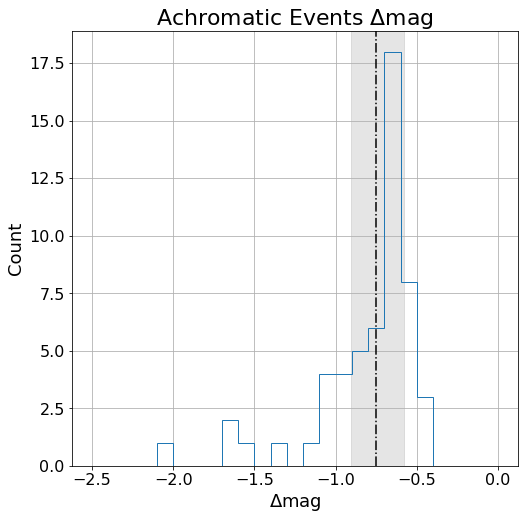

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))
bright_achromatic.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step")
ax.set_title("")
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.axvspan(-2.5 * np.log10(2.3), -2.5 * np.log10(1.7), alpha=0.2, color="tab:gray")
ax.axvline(-2.5 * np.log10(2), color='k', ls="-.")
ax.tick_params(labelsize=16)
ax.set_title(r"Achromatic Events $\Delta$mag", fontsize=22)
plt.show(fig)
fig.savefig(f"{fig_dir}achromatic_events_deltamag.png")
plt.close(fig)

In [42]:
2.5 * np.log10(2) / 4

0.18814374728998826

In [14]:
def hubble_z(omega_r, omega_m, omega_k, omega_lam, z):
    result = np.sqrt(omega_m * (1+z)**3 + omega_r * (1+z)**4 + omega_k * (1 + z)**2 + omega_lam)
    return result

def omega_m_z(omega_m0, omega_k, omega_lam, omega_r, z):
    result = omega_m0 * (1 + z)**3 / hubble_z(omega_r, omega_m0, omega_k, omega_lam, z)**2
    return result

In [23]:
z = np.linspace(0, 10, 1001)
dz = z[1] - z[0]
omega_m = 0.3
omega_lam = 0.7
omega_k = 0
omega_r = 0
w = -1
gam = 0.55 + (1 + w)
little_y = (omega_m_z(omega_m, omega_k, omega_lam, omega_r, z))**gam / (1 + z)
big_y = np.exp(-np.cumsum(little_y * dz))

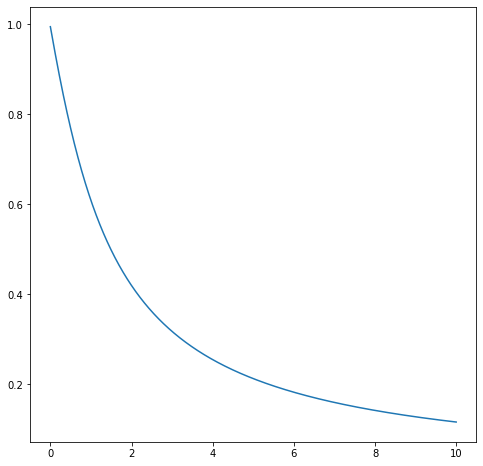

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(z, big_y)
plt.show(fig)